In [2]:
%load_ext autoreload
%autoreload

import time

import numpy as np
from scipy import linalg
import scipy.stats
from scipy import pi,sqrt,exp
from scipy.special import erf

import approximate_diffusion_models
from empirical_estimation import EmpiricalEstimator
from oom_estimation import OOMEstimator
from msm_estimation import MSMEstimator

%pylab inline
rcParams.update({'figure.autolayout': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


D:\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


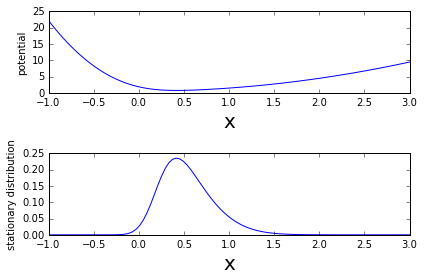

In [3]:
#define the potential and temperature

def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skew(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)

def potential_function(x):
    return -2*log(skew(x,a=4))

beta=2.

f,(ax1,ax2)=subplots(2)

xx=np.linspace(-1,3,100)
vv=np.empty(xx.shape)
for i in range(xx.shape[0]):
    vv[i]=potential_function(xx[i])
ax1.plot(xx,vv)
ax1.set_xlabel('x',fontsize=20)
ax1.set_ylabel('potential',fontsize=10)
ax2.plot(xx,exp(-beta*vv))
ax2.set_xlabel('x',fontsize=20)
ax2.set_ylabel('stationary distribution',fontsize=10)

In [4]:
#define the simulation model
lb=-1.
ub=3.
grid_num=100
delta_t=0.01
diffusion_model=approximate_diffusion_models.OneDimensionalModel(potential_function,beta,lb,ub,grid_num,delta_t)

In [5]:
#calculate true quantities of u: E[y_t], C0: E[y_t**2], C1: E[y_t*y_(t+0.01)]
noise_Sigma2=0.1 #0.01
lags_for_C=[0,1]

u=diffusion_model.expectation()
tmp_C=diffusion_model.correlation_with_noise(lags_for_C,noise_Sigma2)[0]
C0=tmp_C[0]
C1=tmp_C[1]

true_result={'u':u,'C0':C0,'C1':C1}
print true_result

{'C1': 0.36674378132018592, 'C0': 0.47169616209274823, 'u': 0.53401006655541661}


In [6]:
#perform simulations and estimations

start_position=ub #all simulations start from ub=3
traj_length=100 #the simulation length of each trajectory
traj_num=1000 #the number of trajectories
run_num=20 #independently repeat run_num times of simulations and estimations

empirical_result={'u_mem':np.empty(run_num),'C0_mem':np.empty(run_num),'C1_mem':np.empty(run_num)}
msm_result={'u_mem':np.empty(run_num),'C0_mem':np.empty(run_num),'C1_mem':np.empty(run_num)}
oom_result={'u_mem':np.empty(run_num),'C0_mem':np.empty(run_num),'C1_mem':np.empty(run_num)}

msm=MSMEstimator()
oom=OOMEstimator()

for k in range(run_num):

    start_time=time.clock()

    trajs=[diffusion_model.simulate_with_noise(traj_length,noise_Sigma2,x_0=start_position) for _ in range(traj_num)]

    empirical_estimator=EmpiricalEstimator(trajs)
    u=empirical_estimator.expectation()
    tmp_C=empirical_estimator.correlation(np.array(lags_for_C))[0]
    empirical_result['u_mem'][k]=u[0]
    empirical_result['C0_mem'][k]=tmp_C[0,0,0]
    empirical_result['C1_mem'][k]=tmp_C[1,0,0]

    oom.estimate(trajs,trajs)        
    u=oom.expectation()
    tmp_C=oom.correlation(np.array(lags_for_C))[0]
    oom_result['u_mem'][k]=u[0]
    oom_result['C0_mem'][k]=tmp_C[0,0,0]
    oom_result['C1_mem'][k]=tmp_C[1,0,0]

    msm.estimate(trajs,trajs,0.01)       
    u=msm.expectation()
    tmp_C=msm.correlation(np.array(lags_for_C))[0]
    msm_result['u_mem'][k]=u[0]
    msm_result['C0_mem'][k]=tmp_C[0,0,0]
    msm_result['C1_mem'][k]=tmp_C[1,0,0]

    print " k:", k, time.clock()-start_time, "seconds"

#print empirical_result
#print msm_result
#print oom_result
#print true_result

 k: 0 4.95472857715 seconds
 k: 1 5.00483788527 seconds
 k: 2 4.59394402192 seconds
 k: 3 4.59345136558 seconds
 k: 4 4.58345988443 seconds
 k: 5 4.61196251706 seconds
 k: 6 4.56461085281 seconds
 k: 7 4.64307663885 seconds
 k: 8 4.60146606316 seconds
 k: 9 4.6901930597 seconds
 k: 10 4.97474561485 seconds
 k: 11 4.90311748827 seconds
 k: 12 5.17532366495 seconds
 k: 13 4.70695528117 seconds
 k: 14 4.69117796184 seconds
 k: 15 4.66445874516 seconds
 k: 16 4.64156007841 seconds
 k: 17 4.62570147078 seconds
 k: 18 4.6518167729 seconds
 k: 19 4.68311810409 seconds


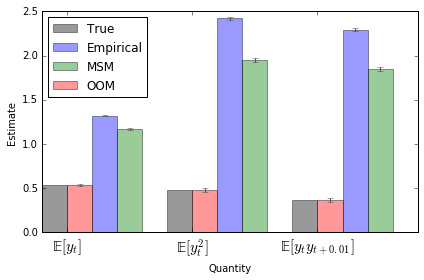

In [7]:
#plot the estimation results

n_groups = 3

means_true=(true_result['u'],true_result['C0'],true_result['C1'])

means_empirical=(np.mean(empirical_result['u_mem']),np.mean(empirical_result['C0_mem']),np.mean(empirical_result['C1_mem']))
std_empirical=(np.std(empirical_result['u_mem']),np.std(empirical_result['C0_mem']),np.std(empirical_result['C1_mem']))
means_msm=(np.mean(msm_result['u_mem']),np.mean(msm_result['C0_mem']),np.mean(msm_result['C1_mem']))
std_msm=(np.std(msm_result['u_mem']),np.std(msm_result['C0_mem']),np.std(msm_result['C1_mem']))
means_oom=(np.mean(oom_result['u_mem']),np.mean(oom_result['C0_mem']),np.mean(oom_result['C1_mem']))
std_oom=(np.std(oom_result['u_mem']),np.std(oom_result['C0_mem']),np.std(oom_result['C1_mem']))

index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects0 = bar(index, means_true, bar_width,
                 alpha=opacity,
                 color='k',
                 error_kw=error_config,
                 label='True')

rects1 = bar(index + 2*bar_width, means_empirical, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=std_empirical,
                 error_kw=error_config,
                 label='Empirical')

rects2 = bar(index + 3*bar_width, means_msm, bar_width,
                 alpha=opacity,
                 color='g',
                 yerr=std_msm,
                 error_kw=error_config,
                 label='MSM')

rects3 = bar(index + bar_width, means_oom, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std_oom,
                 error_kw=error_config,
                 label='OOM')

xlabel('Quantity')
ylabel('Estimate')
xticks(index + bar_width, (r'$\mathrm{\mathbb{E}}[y_t]$', r'$\mathrm{\mathbb{E}}[y_t^2]$', r'$\mathrm{\mathbb{E}}[y_t y_{t+0.01}]$'),fontsize=15)
legend(loc='upper left')

plt.tight_layout()
plt.show()